## Bayes Gaussien

2025-05-28 15:44:04,362 - INFO - Classes trouvées dans les données (noms) : ['Attaques web' 'BENIGN' 'Bot' 'Brute Force' 'DoS' 'Infiltration'
 'PortScan']
2025-05-28 15:44:04,363 - INFO - Classes trouvées dans les données (indices) : [0, 1, 2, 3, 4, 5, 6]
2025-05-28 15:44:04,414 - INFO - Classes dans y avant split : [0 1 2 3 4 5 6]
2025-05-28 15:44:04,451 - INFO - Classes dans y_train : [0 1 2 3 4 5 6]
2025-05-28 15:44:04,452 - INFO - Classes dans y_test : [0 1 2 3 4 5 6]
2025-05-28 15:44:04,483 - INFO - Classes apprises par le modèle : [0 1 2 3 4 5 6]



  === Résultats sur le jeu de test ===
Accuracy      : 0.9337
Precision     : 0.9442
Recall        : 0.9337
F1 Score      : 0.9342
Log Loss      : 2.2432
Validation Croisée (Accuracy) : 0.9254 (±0.0137)

  === Classification Report ===
              precision    recall  f1-score   support

Attaques web      0.969     0.986     0.977       500
      BENIGN      0.941     0.736     0.826       500
         Bot      0.742     0.994     0.850       500
 Brute Force      0.998     0.998     0.998       500
         DoS      0.964     0.916     0.939       500
Infiltration      1.000     0.916     0.956       500
    PortScan      0.996     0.990     0.993       500

    accuracy                          0.934      3500
   macro avg      0.944     0.934     0.934      3500
weighted avg      0.944     0.934     0.934      3500



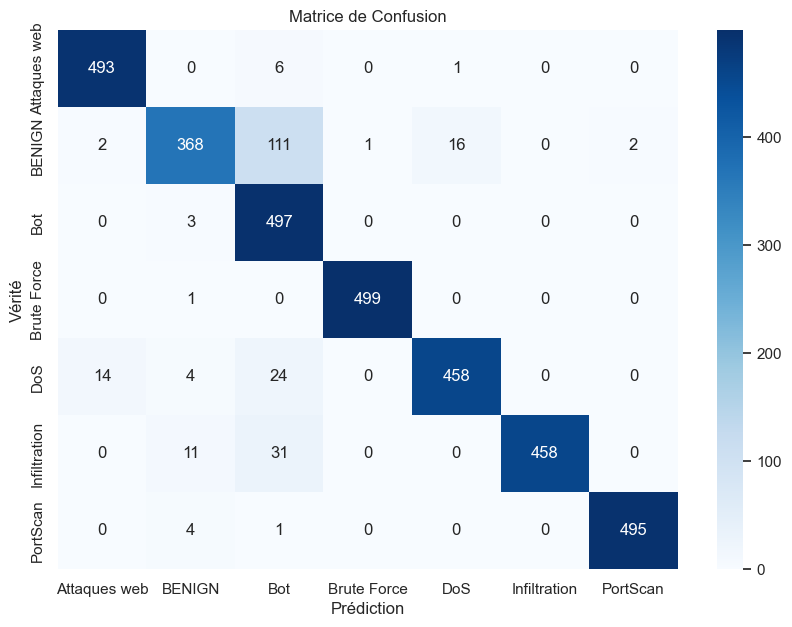

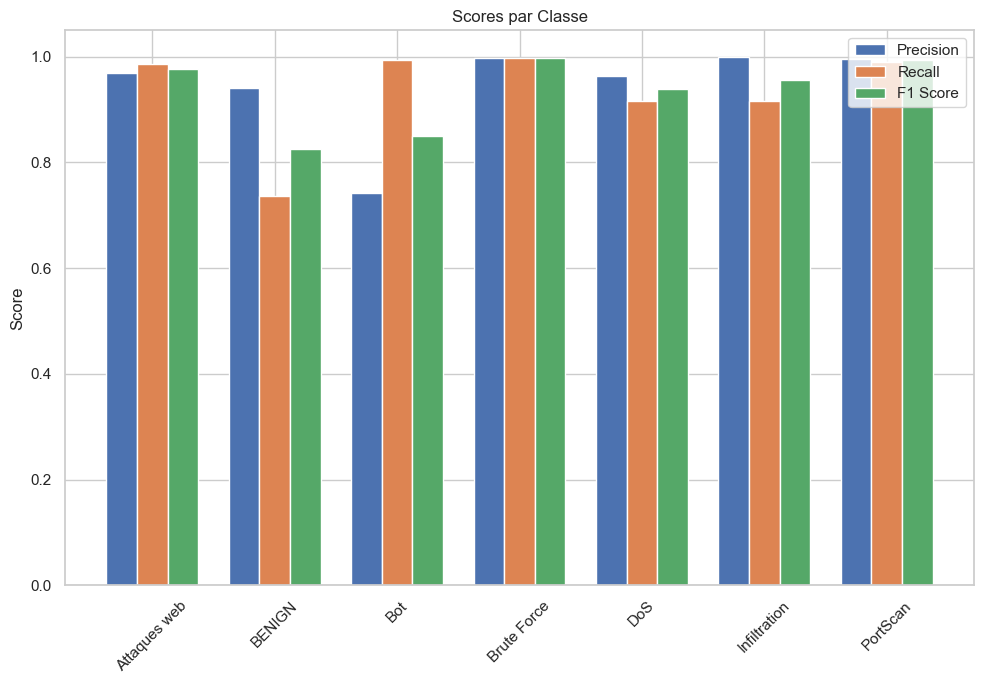


  === Tableau TP / FP / TN / FN par classe ===
         Classe   TP   FP    TN   FN
0  Attaques web  493   16  2984    7
1        BENIGN  368   23  2977  132
2           Bot  497  173  2827    3
3   Brute Force  499    1  2999    1
4           DoS  458   17  2983   42
5  Infiltration  458    0  3000   42
6      PortScan  495    2  2998    5


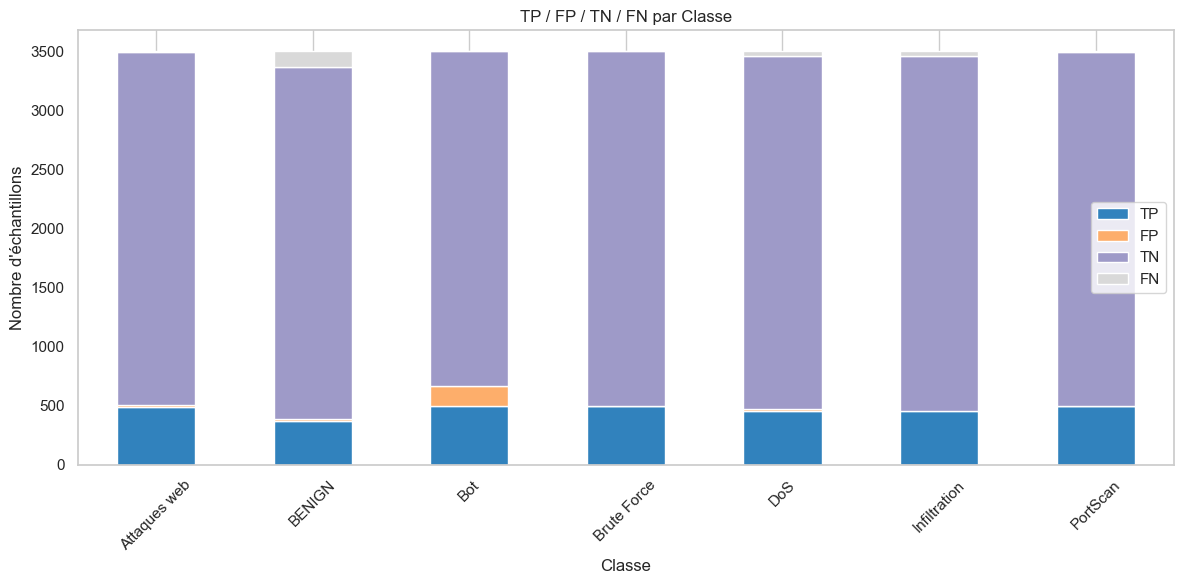

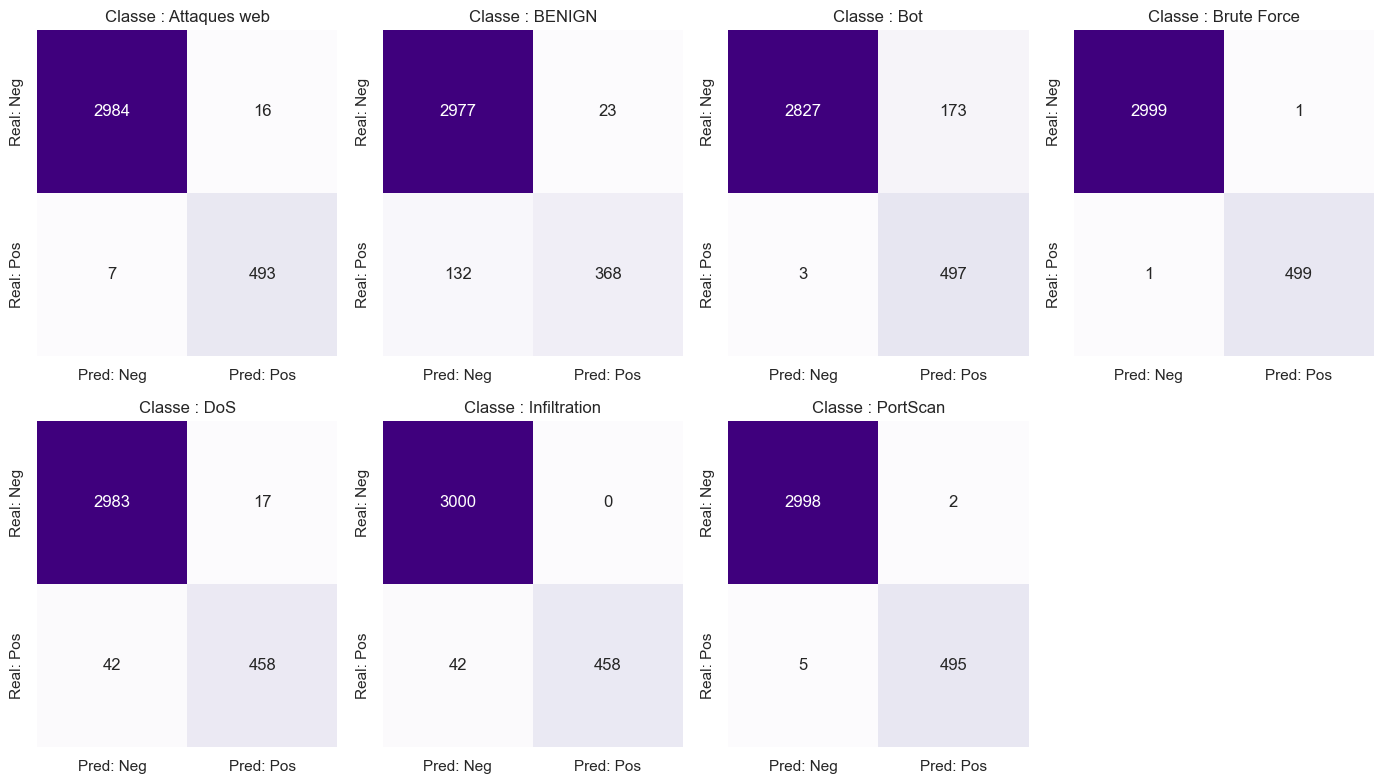

Modèle et préprocesseurs sauvegardés dans 'models/'


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, log_loss,
    classification_report, confusion_matrix, multilabel_confusion_matrix,
    precision_recall_fscore_support, roc_curve, auc
)
from itertools import cycle
import joblib
import os
import logging

DATA_PATH = "C:/Users/ayana/Desktop/IDS project/Data/balanced_data.csv" 
OUTPUT_DIR = "C:/Users/ayana/Desktop/IDS project/Data/plots"
os.makedirs(OUTPUT_DIR, exist_ok=True)
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 7)

def load_and_preprocess_data(data_path):
    """Charge et prétraite les données."""
    try:
        df = pd.read_csv(data_path)
        if "Label" not in df.columns:
            raise KeyError("La colonne 'Label' est absente du dataset.")
        X = df.drop(columns=["Label"])
        y = df["Label"]
        if X.isnull().sum().sum() > 0:
            raise ValueError("Des valeurs manquantes détectées dans les features.")

        le = LabelEncoder()
        y = le.fit_transform(y)  
        class_names = le.classes_  
        class_indices = list(range(len(class_names)))  
        logging.info(f"Classes trouvées dans les données (noms) : {class_names}")
        logging.info(f"Classes trouvées dans les données (indices) : {class_indices}")

        if len(class_names) < 2:
            raise ValueError("Moins de 2 classes détectées dans les données.")

        scaler = StandardScaler()
        X = scaler.fit_transform(X)

        return X, y, class_names, class_indices, scaler, le
    except Exception as e:
        logging.error(f"Erreur lors du prétraitement : {str(e)}")
        raise

def train_evaluate_model(X, y, class_names, class_indices):
    logging.info(f"Classes dans y avant split : {np.unique(y)}")
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

    logging.info(f"Classes dans y_train : {np.unique(y_train)}")
    logging.info(f"Classes dans y_test : {np.unique(y_test)}")
    if len(np.unique(y_train)) < len(class_names):
        logging.warning(f" Certaines classes manquantes dans y_train : {np.unique(y_train)}")

    model = GaussianNB(var_smoothing=5e-9)
    model.fit(X_train, y_train)

    logging.info(f"Classes apprises par le modèle : {model.classes_}")
    if len(model.classes_) < len(class_names):
        logging.warning(f"Modèle n'a appris que {len(model.classes_)} classes au lieu de {len(class_names)}")

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    min_samples_per_class = len(class_names) * 10
    step = int(len(X_train)/10)
    for i in range(min_samples_per_class, len(X_train), step):
        X_train_subset = X_train[:i]
        y_train_subset = y_train[:i]
        model.fit(X_train_subset, y_train_subset)

        y_train_pred = model.predict(X_train_subset)
        y_val_pred = model.predict(X_val)
        train_losses.append(log_loss(y_train_subset, model.predict_proba(X_train_subset), labels=class_indices))
        val_losses.append(log_loss(y_val, model.predict_proba(X_val), labels=class_indices))
        train_accuracies.append(accuracy_score(y_train_subset, y_train_pred))
        val_accuracies.append(accuracy_score(y_val, y_val_pred))

    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)

    acc = accuracy_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred, average="weighted", zero_division=0, labels=class_indices)
    rec = recall_score(y_test, y_test_pred, average="weighted", zero_division=0, labels=class_indices)
    f1 = f1_score(y_test, y_test_pred, average="weighted", zero_division=0, labels=class_indices)
    logloss = log_loss(y_test, y_test_proba, labels=class_indices)

    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()

    return (model, X_train, acc, prec, rec, f1, logloss, y_test, y_test_pred, y_test_proba,
            class_names, class_indices, train_losses, val_losses, train_accuracies,
            val_accuracies, cv_mean, cv_std)

def plot_results(X_train, y_test, y_test_pred, y_test_proba, class_names, class_indices, train_losses,
                 val_losses, train_accuracies, val_accuracies, cv_mean, cv_std):
    cm = confusion_matrix(y_test, y_test_pred, labels=class_indices)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Matrice de Confusion")
    plt.xlabel("Prédiction")
    plt.ylabel("Vérité")
    plt.savefig(os.path.join(OUTPUT_DIR, "confusion_matrix.png"))
    plt.show()

    precisions, recalls, f1s, _ = precision_recall_fscore_support(y_test, y_test_pred, zero_division=0, labels=class_indices)
    x = np.arange(len(class_names))
    width = 0.25
    plt.figure()
    plt.bar(x - width, precisions, width, label='Precision')
    plt.bar(x, recalls, width, label='Recall')
    plt.bar(x + width, f1s, width, label='F1 Score')
    plt.xticks(ticks=x, labels=class_names, rotation=45)
    plt.ylabel("Score")
    plt.title("Scores par Classe")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "class_scores_bar.png"))
    plt.show()

    mcm = multilabel_confusion_matrix(y_test, y_test_pred, labels=class_indices)
    rows = []
    for label, mat in zip(class_names, mcm):
        tn, fp, fn, tp = mat.ravel()
        rows.append({'Classe': label, 'TP': tp, 'FP': fp, 'TN': tn, 'FN': fn})
    df_metrics = pd.DataFrame(rows)
    print("\n  === Tableau TP / FP / TN / FN par classe ===")
    print(df_metrics)

    df_metrics.set_index('Classe')[['TP', 'FP', 'TN', 'FN']].plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20c')
    plt.title("TP / FP / TN / FN par Classe")
    plt.ylabel("Nombre d'échantillons")
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "tp_fp_tn_fn_stacked.png"))
    plt.show()

    fig, axes = plt.subplots(2, 4, figsize=(14, 8))
    axes = axes.ravel()
    for idx, (label, mat) in enumerate(zip(class_names, mcm)):
        sns.heatmap(mat, annot=True, fmt='d', cmap='Purples', cbar=False,
                    xticklabels=['Pred: Neg', 'Pred: Pos'],
                    yticklabels=['Real: Neg', 'Real: Pos'], ax=axes[idx])
        axes[idx].set_title(f"Classe : {label}")
    for idx in range(len(class_names), len(axes)):
        axes[idx].axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "binary_heatmaps.png"))
    plt.show()

    step = int(len(X_train) / 10)
    min_samples_per_class = len(class_names) * 10
    iterations = range(min_samples_per_class, min_samples_per_class + len(train_losses) * step, step)


def main():
    X, y, class_names, class_indices, scaler, le = load_and_preprocess_data(DATA_PATH)

    (model, X_train, acc, prec, rec, f1, logloss, y_test, y_test_pred, y_test_proba,
     class_names, class_indices, train_losses, val_losses, train_accuracies,
     val_accuracies, cv_mean, cv_std) = train_evaluate_model(X, y, class_names, class_indices)

    print("\n  === Résultats sur le jeu de test ===")
    print(f"Accuracy      : {acc:.4f}")
    print(f"Precision     : {prec:.4f}")
    print(f"Recall        : {rec:.4f}")
    print(f"F1 Score      : {f1:.4f}")
    print(f"Log Loss      : {logloss:.4f}")
    print(f"Validation Croisée (Accuracy) : {cv_mean:.4f} (±{cv_std:.4f})")

    print("\n  === Classification Report ===")
    print(classification_report(y_test, y_test_pred, target_names=class_names, digits=3))

    plot_results(X_train, y_test, y_test_pred, y_test_proba, class_names, class_indices,
                 train_losses, val_losses, train_accuracies, val_accuracies, cv_mean, cv_std)

    joblib.dump(model, 'C:/Users/ayana/Desktop/IDS project/models/naive_bayes_model.pkl')
    joblib.dump(scaler, 'C:/Users/ayana/Desktop/IDS project/models//scaler.pkl')
    joblib.dump(le, 'C:/Users/ayana/Desktop/IDS project/models/label_encoder.pkl')
    print("Modèle et préprocesseurs sauvegardés dans 'models/'")

if __name__ == "__main__":
    main()


##